# Introduction

<p>Built a simple convolutional neural network with two convolutional layer, relu activation function and maxplool layer. The loss fucntion used is cross entropy loss with Adam optimizer.</p>
<p>Results: 95% accuracy</p>

# Importing the required libraries

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

import torchvision
import torchvision.transforms as transform
from torchvision.datasets import ImageFolder, DatasetFolder
from torchvision import models

from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Data and Transformation

In [2]:
# The required transformation on images

image_transform = transform.Compose(
                                        [transform.Resize(size = (32, 32)),
                                         transform.ToTensor(),
#                                          transform.Grayscale(),
                                         transform.Normalize((0.5,0.5, 0.5), (0.5, 0.5, 0.5))
                                        ]
                                   )

In [3]:
# the path to my dataset
path = '../input/face-mask-dataset/data/'

In [4]:
# loading the dataset into the imagefolder object in pytorch

dataset = ImageFolder(
                         root = path,
                         transform= image_transform
                     )
dataset

Dataset ImageFolder
    Number of datapoints: 7553
    Root location: ../input/face-mask-dataset/data/
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [5]:
# Reordering the labels
print(f"class beforer re-ordering: {dataset.class_to_idx}")
# reordering the class so that it makes readability
dataset.class_to_idx = {'with_mask': 1, 'without_mask': 0}
print(f"class after re-ordering: {dataset.class_to_idx}")

class beforer re-ordering: {'with_mask': 0, 'without_mask': 1}
class after re-ordering: {'with_mask': 1, 'without_mask': 0}


In [6]:
index_class = {v : k for k, v in dataset.class_to_idx.items()}
index_class

{1: 'with_mask', 0: 'without_mask'}

In [7]:
# visualising the distribution of labels in the dataset
count_dictionary = {k:0 for k, v in dataset.class_to_idx.items()}
for ele in dataset:
    idx = ele[-1]
    val = index_class[idx]
    count_dictionary[val]+=1

print(f"The count of labels: {count_dictionary}")

The count of labels: {'with_mask': 3828, 'without_mask': 3725}


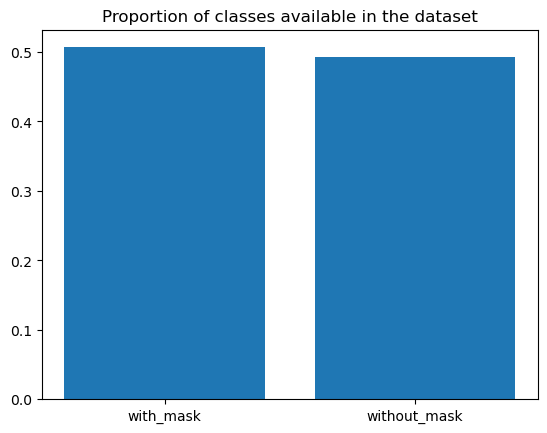

In [8]:
values = list(count_dictionary.values())
labels = list(count_dictionary.keys())

plt.bar(range(len(count_dictionary)), [val / sum(values) for val in values], tick_label = labels)
plt.title("Proportion of classes available in the dataset")
plt.show()

In [9]:
train_data, val_data = random_split(dataset, (5300, 2253))
val_data, test_data = random_split(val_data, (1126, 1127))

In [10]:
# verifying if any images leftover
len(train_data) + len(val_data) + len(test_data) == len(dataset)

True

In [11]:
# creating dataloader instances of the train, valid, and test
trainloader = DataLoader(dataset=train_data, shuffle=True, batch_size=4, num_workers=1)
validloader = DataLoader(dataset=val_data, shuffle=True, batch_size=4, num_workers=1)
testloader = DataLoader(dataset=test_data, shuffle=True, batch_size=4, num_workers=1)

           with_mask            with_mask         without_mask         without_mask


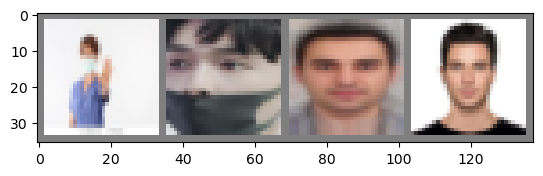

In [12]:
# visualising some of the images

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg , (1, 2, 0)))


viz_iter = iter(trainloader)
images, labels = next(viz_iter)


imshow(torchvision.utils.make_grid(images))

classes = ('with_mask', 'without_mask')
print(' '.join('%20s' % classes[labels[j]] for j in range(4)))

# Model

In [13]:
# Simple model

class FaceMaskNet(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x, y, train = False):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        if train:
            loss = nn.CrossEntropyLoss()(x, y)
            return x, loss
    
        return x

In [19]:
DEVICE = 'cuda'
EPOCHS = 15
model = FaceMaskNet()
model.to(DEVICE)
# criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [20]:
# training the model

def train_fn(dataloader, model, optimizer):
    
    model.train()
    
    total_loss = 0.0
    
    for images, labels in tqdm(dataloader):
        
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        
        optimizer.zero_grad()
        out, loss = model(images, labels, train = True)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(dataloader)
        

In [21]:
def eval_fn(dataloader, model):
    
    model.eval()
    total_loss = 0.0
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            out, loss = model(images, labels, train = True)

            total_loss += loss.item()
        
    return total_loss / len(dataloader)            

In [22]:
best_val_loss = np.inf

train_loss_track = []
val_loss_track = []

for epoch in range(EPOCHS):
    
    train_loss = train_fn(trainloader, model, optimizer)
    val_loss = eval_fn(validloader, model)
    
    train_loss_track.append(train_loss)
    val_loss_track.append(val_loss)
    
    if val_loss < best_val_loss: #this is to ensure the best model is stored
        torch.save(model.state_dict(), 'best_model.pt') 
        print("Saved model!")
        best_val_loss = val_loss
        
    print(f"Epoch {epoch+1} train loss: {train_loss} valid loss: {val_loss}")

100%|██████████| 282/282 [00:06<00:00, 45.37it/s]


Saved model!
Epoch 1 train loss: 0.38156944658255804 valid loss: 0.33873486848476225


100%|██████████| 282/282 [00:05<00:00, 48.23it/s]


Saved model!
Epoch 2 train loss: 0.2242500484118651 valid loss: 0.2546584903054494


100%|██████████| 282/282 [00:06<00:00, 45.92it/s]


Saved model!
Epoch 3 train loss: 0.17771487172398132 valid loss: 0.23502673156037662


100%|██████████| 282/282 [00:05<00:00, 47.08it/s]


Saved model!
Epoch 4 train loss: 0.15835572891033975 valid loss: 0.18723123992817206


100%|██████████| 282/282 [00:06<00:00, 42.47it/s]


Saved model!
Epoch 5 train loss: 0.13417282564695787 valid loss: 0.18193527756767439


100%|██████████| 282/282 [00:05<00:00, 47.99it/s]


Epoch 6 train loss: 0.12038920855658503 valid loss: 0.2070445494676823


100%|██████████| 282/282 [00:06<00:00, 45.99it/s]


Epoch 7 train loss: 0.10254903327574637 valid loss: 0.19828670120604336


100%|██████████| 282/282 [00:05<00:00, 47.96it/s]


Epoch 8 train loss: 0.08076097194016386 valid loss: 0.3474383322828042


100%|██████████| 282/282 [00:06<00:00, 44.43it/s]


Epoch 9 train loss: 0.07790142803657782 valid loss: 0.22365819239089335


100%|██████████| 282/282 [00:06<00:00, 42.93it/s]


Epoch 10 train loss: 0.06044651359626858 valid loss: 0.2988599141468957


100%|██████████| 282/282 [00:06<00:00, 44.75it/s]


Epoch 11 train loss: 0.05503227401462501 valid loss: 0.3661772203415134


100%|██████████| 282/282 [00:05<00:00, 47.93it/s]


Epoch 12 train loss: 0.0475046540223379 valid loss: 0.3128361842201939


100%|██████████| 282/282 [00:06<00:00, 45.45it/s]


Epoch 13 train loss: 0.04033699980378817 valid loss: 0.3575234529760671


100%|██████████| 282/282 [00:05<00:00, 48.09it/s]


Epoch 14 train loss: 0.04357600540788729 valid loss: 0.29561247378313565


100%|██████████| 282/282 [00:07<00:00, 40.10it/s]

Epoch 15 train loss: 0.026641854635311882 valid loss: 0.49435609519724255


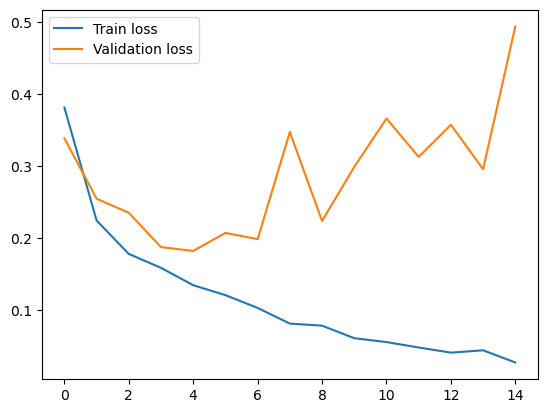

In [23]:
# plotting the train and the validation loss

plt.plot(train_loss_track, label = 'Train loss')
plt.plot(val_loss_track, label = 'Validation loss')
plt.legend();

In [24]:
model

FaceMaskNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

# Test and Results

In [25]:
# loading the best model saved during training
# testing the data
model_2 =  FaceMaskNet()
model_2.load_state_dict(torch.load('/kaggle/working/best_model.pt'))
model_2.eval()

FaceMaskNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [41]:
def test_fn(dataloader, model):
    
    model.cuda()
    images_ls = []
    real_vals = []
    preds = []
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            
            real_vals.extend(labels.tolist())

            out = model(images, labels, train = False)
            pred = torch.argmax(out,axis=1).tolist()
            preds.extend(pred)
#             to plot the images
            images_ls.append([images, labels, pred])
            
#             correct_pred += torch.sum(torch.argmax(out,axis=1)== labels).item()
#             total_pred += len(images)
    
    return real_vals, preds, images_ls

In [42]:
y, y_hats, plot_info = test_fn(testloader, model_2)

100%|██████████| 282/282 [00:07<00:00, 39.27it/s]


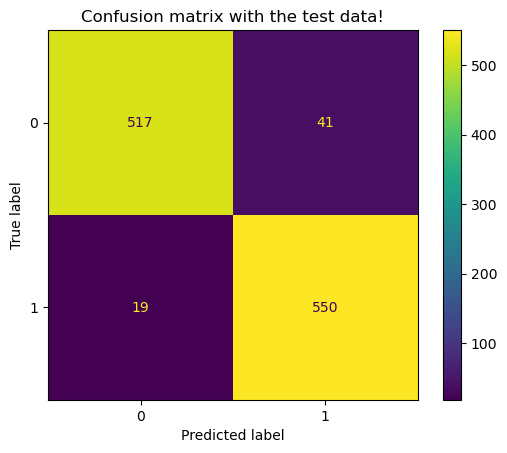

In [28]:
cm = confusion_matrix(y, y_hats)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion matrix with the test data!")
plt.show();

In [29]:
print("Classification report of the test data!")
print(classification_report(y, y_hats))

Classification report of the test data!
              precision    recall  f1-score   support

           0       0.96      0.93      0.95       558
           1       0.93      0.97      0.95       569

    accuracy                           0.95      1127
   macro avg       0.95      0.95      0.95      1127
weighted avg       0.95      0.95      0.95      1127



In [30]:
y, y_hats = test_fn(validloader, model_2)

100%|██████████| 282/282 [00:06<00:00, 42.47it/s]


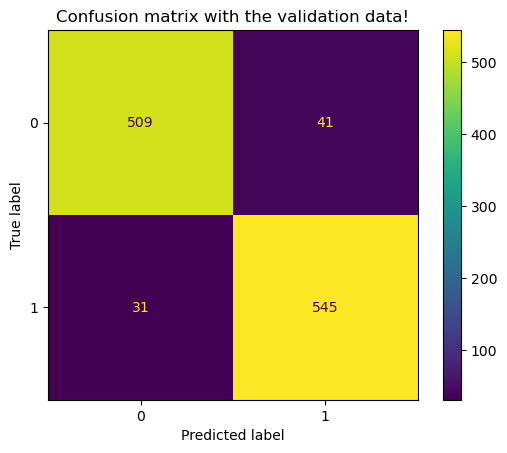

In [31]:
cm = confusion_matrix(y, y_hats)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion matrix with the validation data!")
plt.show();

In [66]:
# visualising some of the images

def test_imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg , (1, 2, 0)))
    plt.show()

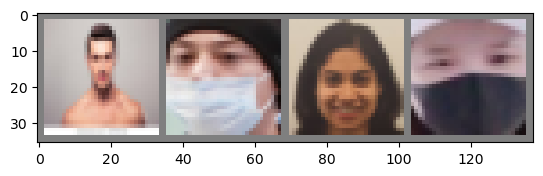

Predictions: 1: without_mask 2: with_mask 3: without_mask 4: with_mask


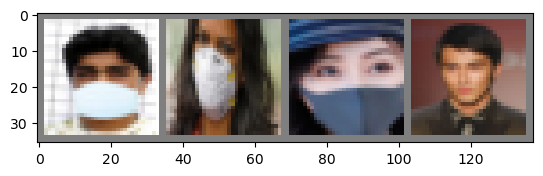

Predictions: 1: with_mask 2: with_mask 3: with_mask 4: without_mask


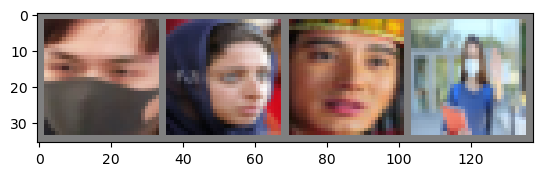

Predictions: 1: with_mask 2: without_mask 3: without_mask 4: with_mask


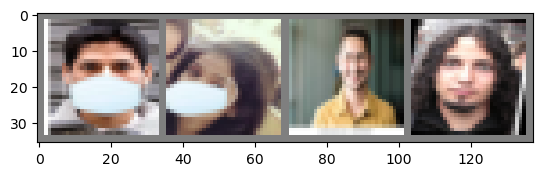

Predictions: 1: with_mask 2: with_mask 3: without_mask 4: without_mask


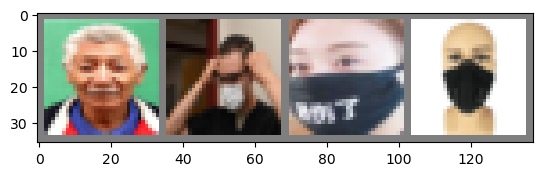

Predictions: 1: without_mask 2: with_mask 3: with_mask 4: with_mask


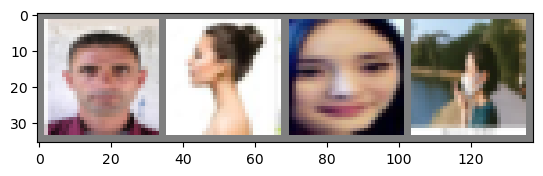

Predictions: 1: without_mask 2: with_mask 3: without_mask 4: with_mask


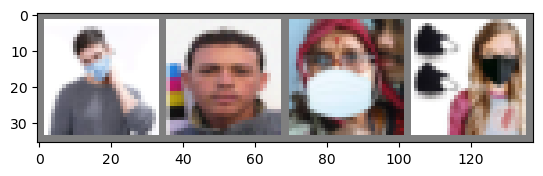

Predictions: 1: with_mask 2: without_mask 3: with_mask 4: with_mask


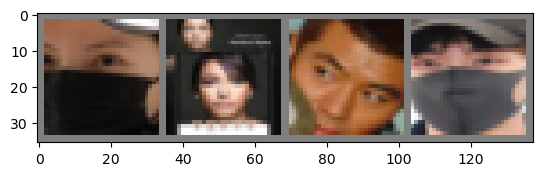

Predictions: 1: with_mask 2: without_mask 3: without_mask 4: with_mask


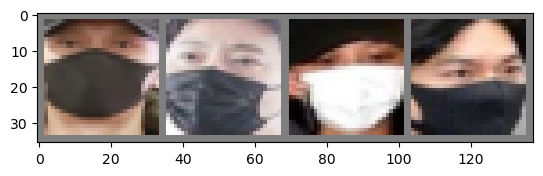

Predictions: 1: with_mask 2: with_mask 3: with_mask 4: with_mask


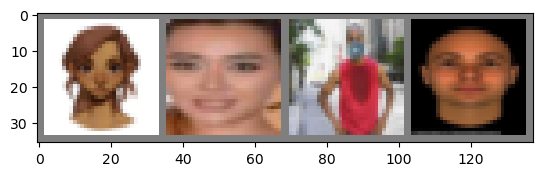

Predictions: 1: without_mask 2: without_mask 3: without_mask 4: without_mask


In [68]:
for plot in plot_info[:10]:
    imshow(torchvision.utils.make_grid(plot[0].cpu()))
    classes = ('with_mask', 'without_mask')
    print("Predictions:", end=" ")
    print(' '.join(f'{str(j+1)}: %5s' % classes[plot[2][j]] for j in range(4)))